# Metric Analysis for ECON model

In [27]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
import torchinfo
import numpy as np
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
import ast
import os
import sys

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from gradient import Gradient
from hessian import Hessian
from CKA import CKA
from neural_efficiency import NeuralEfficiency
from fisher import Fisher




Select the desired ECON model:

In [28]:
base_path = "/data/tbaldi/checkpoint/"
batch_size = 1024
learning_rate = 0.0015625
precision = 8
size = 'small'

In [29]:
def load_model(path, batch_size, learning_rate, precision, size):
    model_path = path + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_1_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model


model = load_model(base_path, batch_size, learning_rate, precision, size)
torchinfo.summary(model, input_size=(1, 1, 8, 8))  # (B, C, H, W)     

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 8, 8]              --
├─QuantizedEncoder: 1-1                  [1, 16]                   --
│    └─QuantAct: 2-1                     [1, 1, 8, 8]              --
│    └─QuantConv2d: 2-2                  [1, 1, 4, 4]              20
│    └─ReLU: 2-3                         [1, 1, 4, 4]              --
│    └─QuantAct: 2-4                     [1, 1, 4, 4]              --
│    └─Flatten: 2-5                      [1, 16]                   --
│    └─QuantLinear: 2-6                  [1, 16]                   272
│    └─ReLU: 2-7                         [1, 16]                   --
├─Sequential: 1-2                        [1, 1, 8, 8]              --
│    └─Linear: 2-8                       [1, 128]                  2,176
│    └─ReLU: 2-9                         [1, 128]                  --
│    └─Unflatten: 2-10                   [1, 8, 4, 4]              --
│    └─Conv

Setup the data loader:

In [30]:
data_path = '../../data/ECON/Elegun'
processed_file = 'nELinks5.npy'

def get_data_module(batch_size):
    data_module = AutoEncoderDataModule(
        data_dir=data_path,
        data_file=os.path.join(data_path, processed_file),
        batch_size=batch_size,
        num_workers=4
        )
    # checek if we have processed the data
    if not os.path.exists(os.path.join(data_path, processed_file)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

data_module = get_data_module(batch_size)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


Model performances:

In [31]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

def compute_EMD(bs, lr, size, precision, load=True):
    if load:
        print("Loading the EMD...")
        emd_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_1.txt'
        # load the achieved EMD of the model
        emd = None
        try:
            emd_file = open(emd_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            emd_file.close()
            return emd
        except Exception as e:
            print("ATTENTION: not able to open the file with the EMD content!")
        
    print("Computing the EMD...")
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader(), verbose=False)
    return avg_emd
    



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## (Estimated) Fisher trace

In [32]:
_, val_loader = data_module.dataloaders()

metric = Fisher(
    model=model,
    data_loader=val_loader,
    optimizer=model.configure_optimizers(),
    target_layers=['encoder.conv', 'encoder.enc_dense']
)

metric.compute()

Computing the Fisher estimated trace...
{'encoder.conv': 0.00026107699640335577, 'encoder.enc_dense': 0.00019609193997648805}


## Hessian 

In [33]:

# _, val_loader = data_module.dataloaders()

# metric = Hessian(
#     model=model,
#     data_loader=val_loader,
#     loss=model.loss
# )

# results = metric.compute()
# results

## CKA similarity

Extract the features from each layer of the model:

In [34]:
model = load_model(base_path, 512, 0.05, 9, 'small')
data_module = get_data_module(batch_size)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


In [35]:
metric = CKA(model, 
             data_module.test_dataloader(),
             activation_layers=['encoder.relu1', 'encoder.relu2'])

result = metric.compute()


Computing the CKA similarity...
CKA matrix:                encoder.relu1  encoder.relu2
encoder.relu1       0.000000       0.254787
encoder.relu2       0.254787       0.000000
average CKA: 0.2547873550906932


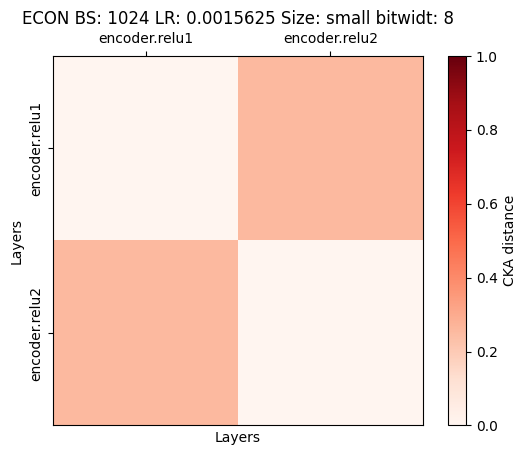

In [36]:
def plot_cka_heatmap(cka_values, title, x_label='Layers', y_label='Layers'):
    # Create a heatmap
    ax = plt.imshow(cka_values.values, 
            cmap='Reds', 
            interpolation='nearest',
            vmin=0,
            vmax=1)

    # Customize the plot
    plt.colorbar(label='CKA distance')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Set axis ticks based on the dimensions
    plt.xticks(np.arange(len(cka_values.columns)), cka_values.columns, rotation='horizontal')
    plt.yticks(np.arange(len(cka_values.index)), cka_values.index, rotation='vertical', va='center')
    
    
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Display the plot
    plt.show()
    
plot_cka_heatmap(result['cka_dist'], 
                 f"ECON BS: {batch_size} LR: {learning_rate} Size: {size} bitwidt: {precision}")

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
CKA matrix:                    [2] encoder.relu1  [2] encoder.relu2
[1] encoder.relu1           0.004023           0.062896
[1] encoder.relu2           0.040965           0.085191
average CKA: 0.04460696266101118


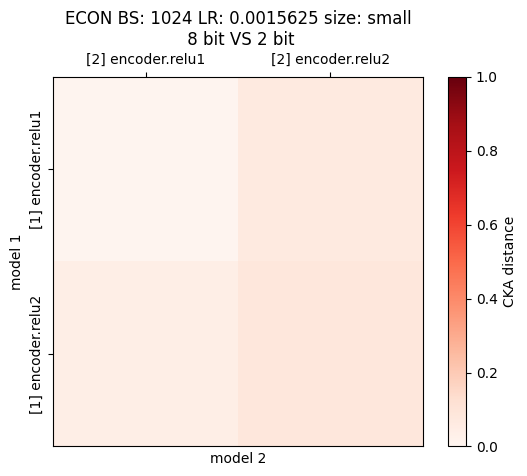

In [37]:
model_small = load_model(base_path, 1024, learning_rate, 8, 'small')
data_module_small = get_data_module(1024)

model_baseline = load_model(base_path, 1024, learning_rate, 2, 'small')
data_module_baseline = get_data_module(1024)

activation_layers=['encoder.relu1', 'encoder.relu2']

metric = CKA(model_small, 
             data_module_small.test_dataloader(),
             activation_layers=activation_layers)

result = metric.compare(model_baseline, 
                        data_module_baseline.test_dataloader(), 
                        activation_layers)


plot_cka_heatmap(result['cka_dist'], 
                 f"ECON BS: {batch_size} LR: {learning_rate} size: {size}\n 8 bit VS 2 bit",
                 x_label='model 2',
                 y_label='model 1')

## Neural Efficiency

In [38]:
model = load_model(base_path, 512, 0.0125, 8, 'small')
data_module = get_data_module(1)
emd = compute_EMD(512, 0.0125, 'small', 8)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Loading the EMD...


In [39]:
metric = NeuralEfficiency(model.encoder, data_module.test_dataloader(), performance=emd)
result = metric.compute(beta=0.5)

result

Computing the Neural efficiency...


/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:97: UserWarning: Attention: the layer conv has tuple as features!
  warnings.warn(f"Attention: the layer " + name + " has tuple as features!")
/home/tbaldi/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:93: UserWarning: Attention: the layer conv.conv has None features!
  warnings.warn(f"Attention: the layer " + name + " has None features!")


layers neural efficiency:
 {'conv': 0.24863508207115453, 'enc_dense': 0.03499136621287039}
network neural efficiency:
 0.09327422586180414
aIQ
 0.221903945204418


{'layers_efficiency': {'conv': 0.24863508207115453,
  'enc_dense': 0.03499136621287039},
 'network_efficiency': 0.09327422586180414,
 'aIQ': 0.221903945204418}

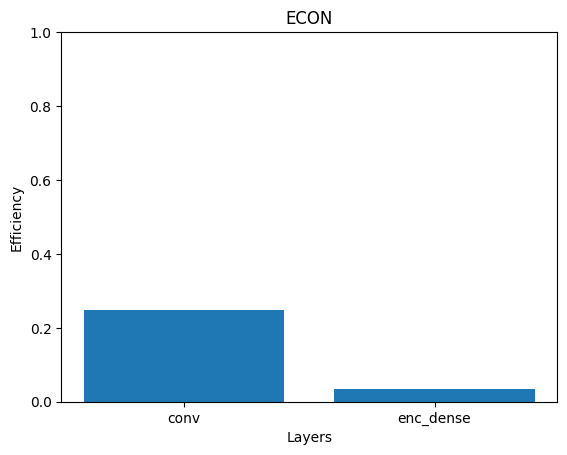

In [40]:
def plot_neural_efficiency_per_layer(neural_efficiency_values, 
                                     title, 
                                     x_label='Layers', 
                                     y_label='Efficiency'):
    # Create a heatmap
    plt.bar(neural_efficiency_values.keys(), 
            neural_efficiency_values.values())

    plt.ylim(0, 1)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()
    

plot_neural_efficiency_per_layer(result['layers_efficiency'], 'ECON')